# Consolidation of intersections

Whereas routing and transportation analysis of street networks must take into account precise street segment directionality and multiple street lanes, morphological analysis in these graphs considers only a coarsened version of their geometry. Details such as four-way intersections, transit exchanges, and roundabouts are often considered geometric "noise" and must be cleaned prior to analysis.

A particular issue arises when considering the intersection of multi-lane streets. Two perpendicular two-lane streets will intersect in four points, often creating a dummy city block---a polygon enclosed by street segments---in the network. This artifact can influence metrics on urban form such as block area or block eccentricity. We would prefer that these intersections were consolidated in a single vertex.

The following code exemplifies a simple process for intersection consolidation in street networks using `momepy.consolidate_intersections()`.

In [1]:
import momepy as mm

## Load data

For this example we will fetch some data from [OpenStreetMap](https://www.openstreetmap.org/#map=6/40.007/-2.488) (using `osmnx`). The function default arguments for attribute naming are configured for such source. However, any user-defined street network can be passed as input to `consolidate_intersections` as long as it satisfies two conditions:

1. All nodes have attributes determining their x (`x_att`) and y (`y_att`) coordinates;
2. All edges have attributes determining their origin (`edge_from_att`), destination (`edge_to_att`), and geometry.

These attribute names can be passed as input to the function.

We download a 1-square km street network from New York, USA, and reproject to its local CRS.

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_93532/1626776931.py:10: FutureWarning: The `get_undirected` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_undirected` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  graph_undirected = ox.get_undirected(graph_projected)


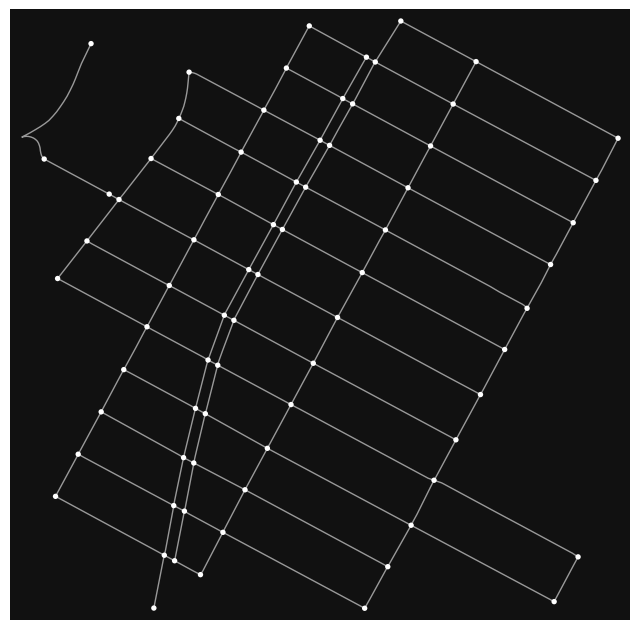

In [2]:
import osmnx as ox

center = (40.783169, -73.978315)
radius = 500

graph = ox.graph_from_point(
    (40.783169, -73.978315), dist=500, network_type="drive"
)
graph_projected = ox.project_graph(graph)
graph_undirected = ox.get_undirected(graph_projected)

fig, ax = ox.plot_graph(graph_undirected)

One of the streets has two parallel lanes creating the problem described above.

## Default behavior

In addition to the graph, the function also receives as argument a `tolerance` value. This is the critical length of street segments in the processed network: any segment below such value will be collapsed. Values between 20 and 30 (default) meters work well.

In [3]:
consolidated_graph = mm.consolidate_intersections(
    graph_undirected, tolerance=30
)

The graph maintains all its attributes, and can be drawn using the same functions:

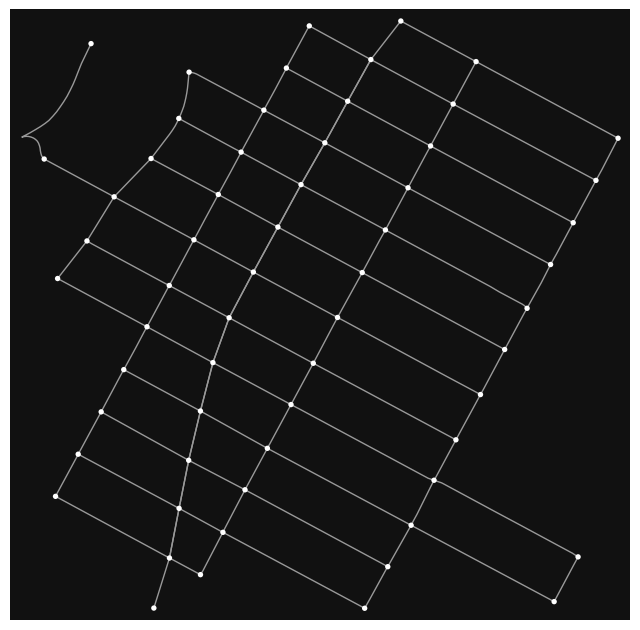

In [4]:
fig, ax = ox.plot_graph(consolidated_graph)

## Simplification methods

By default, the function rebuilds the graph. Setting the parameter `rebuild_graph` to `False` returns a graph where edges to and from consolidated clusters do not exist. This method is faster and useful for aggregation and summary statistics---e.g. the number and location of intersections.

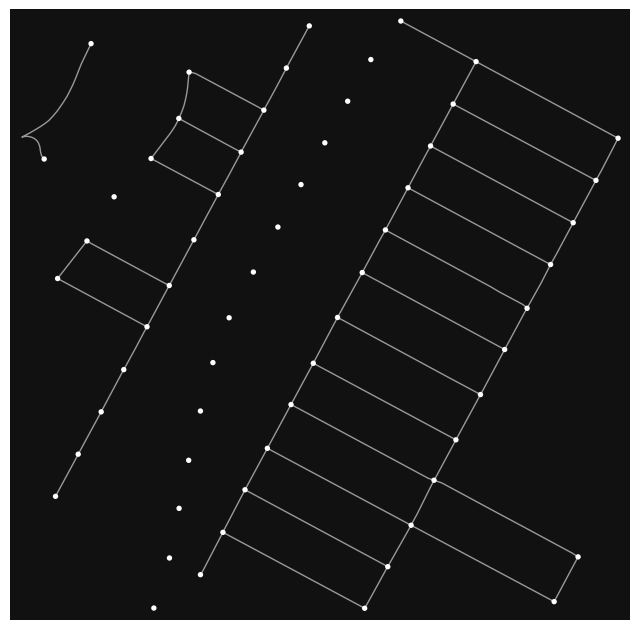

In [5]:
rebuildfalse_graph = mm.consolidate_intersections(
    graph_undirected, tolerance=30, rebuild_graph=False
)
fig, ax = ox.plot_graph(rebuildfalse_graph)

When `rebuild_graph` is set to `True`, the user can choose a method to determine the geometry of new edges with the parameter `rebuild_edges_method`. There are three currently implemented methods:

1. `extend` reconstruction: Edges are linearly extended from original endpoints until the new nodes. This method preserves most faithfully the network geometry, but often yields non-planar graphs with overlapping edges.

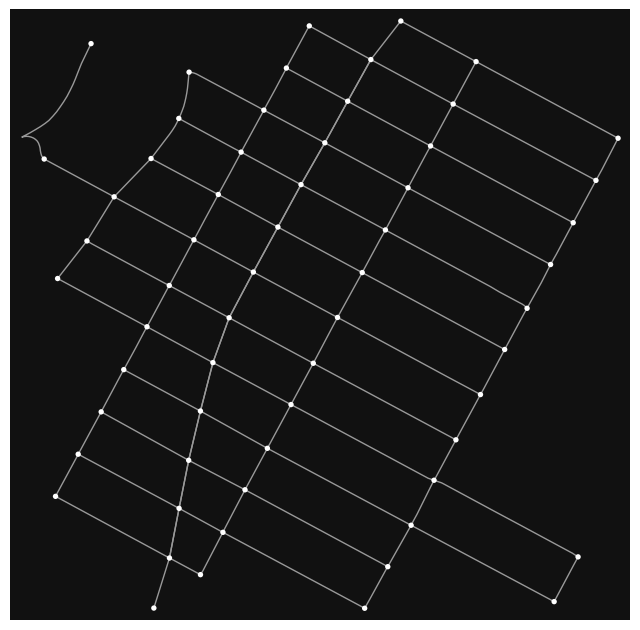

In [6]:
extend_graph = mm.consolidate_intersections(
    graph_undirected, tolerance=30, rebuild_edges_method="extend"
)
fig, ax = ox.plot_graph(extend_graph)

2. `spider` reconstruction [default]: Edges are cropped within a buffer of the new endpoints and linearly extended from there. This method improves upon linear reconstruction by mantaining, when possible, network planarity. This is the same network that we obtained beforehand.

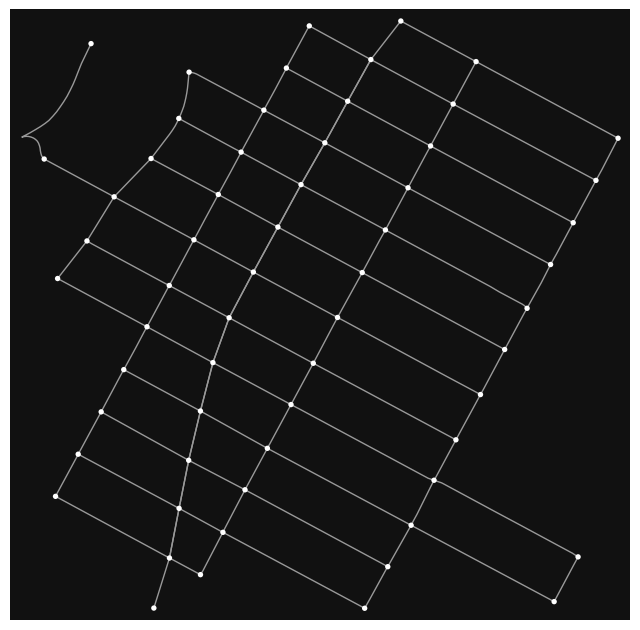

In [7]:
spider_graph = mm.consolidate_intersections(
    graph_undirected, tolerance=30, rebuild_edges_method="spider"
)
fig, ax = ox.plot_graph(spider_graph)

3. `euclidean` reconstruction: Edges are ignored and new edges are built as straightlines between new origin and new destination. This method ignores geometry, but efficiently preserves adjacency.

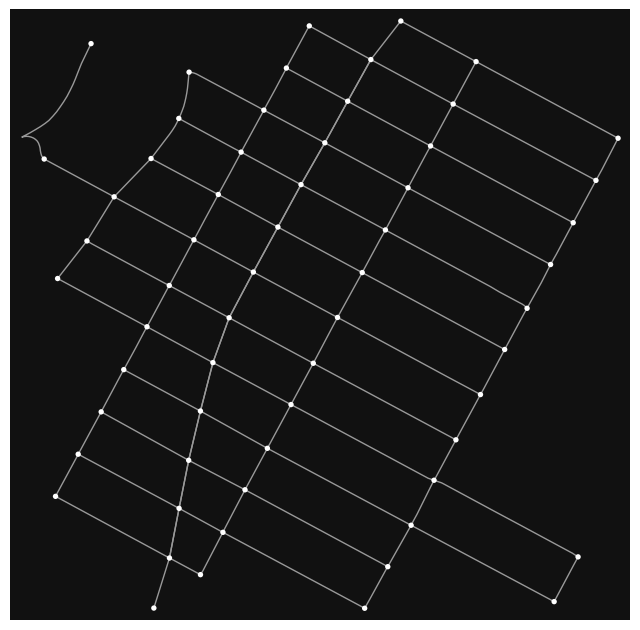

In [8]:
euclidean_graph = mm.consolidate_intersections(
    graph_undirected, tolerance=30, rebuild_edges_method="euclidean"
)
fig, ax = ox.plot_graph(euclidean_graph)